# Downloading Our World in Data

Our World in Data [recently announced](https://ourworldindata.org/easier-to-reuse-our-data) that they are providing APIs to access their data.
Coincidentally, I am using one of their datasets in my [workshop on time series analysis at PyData Global 2024](https://global2024.pydata.org/cfp/talk/KLXYKX/).
So I took this opportunity to update my example using the new API -- this notebook shows what I learned.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkStats/blob/v3/examples/temperature.ipynb).
It is based on Chapter 12 of [*Think Stats*, third edition](https://allendowney.github.io/ThinkStats/).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Air Temperature

In the chapter on time series analysis, in an exercise on seasonal decomposition, I use monthly average surface temperatures in the United States, from a [dataset from Our World in Data](https://ourworldindata.org/grapher/average-monthly-surface-temperature) that includes "temperature [in Celsius] of the air measured 2 meters above the ground, encompassing land, sea, and in-land water surfaces," for most countries in the world from 1941 to 2024.

The following cells download and display the metadata that describes the dataset.

In [2]:
import requests

url = (
    "https://ourworldindata.org/grapher/"
    "average-monthly-surface-temperature.metadata.json"
)
query_params = {"v": "1", "csvType": "full", "useColumnShortNames": "true"}
headers = {"User-Agent": "Our World In Data data fetch/1.0"}

response = requests.get(url, params=query_params, headers=headers)
metadata = response.json()

The result is a nested dictionary. Here are the top-level keys.

In [3]:
metadata.keys()

dict_keys(['chart', 'columns', 'dateDownloaded'])

Here's the chart-level documentation.

In [4]:
from pprint import pprint

pprint(metadata["chart"])

{'citation': 'Contains modified Copernicus Climate Change Service information '
             '(2019)',
 'originalChartUrl': 'https://ourworldindata.org/grapher/average-monthly-surface-temperature?v=1&csvType=full&useColumnShortNames=true',
 'selection': ['World'],
 'subtitle': 'The temperature of the air measured 2 meters above the ground, '
             'encompassing land, sea, and in-land water surfaces.',
 'title': 'Average monthly surface temperature'}


And here's the documentation of the column we'll use.

In [5]:
pprint(metadata["columns"]["temperature_2m"])

{'citationLong': 'Contains modified Copernicus Climate Change Service '
                 'information (2019) – with major processing by Our World in '
                 'Data. “Annual average” [dataset]. Contains modified '
                 'Copernicus Climate Change Service information, “ERA5 monthly '
                 'averaged data on single levels from 1940 to present 2” '
                 '[original data].',
 'citationShort': 'Contains modified Copernicus Climate Change Service '
                  'information (2019) – with major processing by Our World in '
                  'Data',
 'descriptionKey': [],
 'descriptionProcessing': '- Temperature measured in kelvin was converted to '
                          'degrees Celsius (°C) by subtracting 273.15.\n'
                          '\n'
                          '- Initially, the temperature dataset is provided '
                          'with specific coordinates in terms of longitude and '
                          'latitude. To

The following cells download the data for the United States -- to see data from another country, change `country_code` to almost any [three-letter ISO 3166 country codes](https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes#Current_ISO_3166_country_code).

In [6]:
country_code = "USA"  # replace this with other three-letter country codes
base_url = (
    "https://ourworldindata.org/grapher/" 
    "average-monthly-surface-temperature.csv"
)

query_params = {
    "v": "1",
    "csvType": "filtered",
    "useColumnShortNames": "true",
    "tab": "chart",
    "country": country_code,
}

In [7]:
from urllib.parse import urlencode

url = f"{base_url}?{urlencode(query_params)}"
temp_df = pd.read_csv(url, storage_options=headers)

In general, you can find out which query parameters are supported by exploring the dataset online and pressing the download icon, which displays a URL with query parameters corresponding to the filters you selected by interacting with the chart.

In [8]:
temp_df.head()

,Entity,Code,year,Day,temperature_2m,temperature_2m.1
0,United States,USA,1941,1941-12-15,-1.878019,8.016244
1,United States,USA,1942,1942-01-15,-4.776551,7.848984
2,United States,USA,1942,1942-02-15,-3.870868,7.848984
3,United States,USA,1942,1942-03-15,0.097811,7.848984
4,United States,USA,1942,1942-04-15,7.537291,7.848984


The resulting `DataFrame` includes the column that's documented in the metadata, `temperature_2m`, and an additional undocumented column, which might be an annual average.

For this example, we'll use the monthly data.

In [9]:
temp_series = temp_df["temperature_2m"]
temp_series.index = pd.to_datetime(temp_df["Day"])

Here's what it looks like.

Text(0, 0.5, 'Surface temperature (℃)')

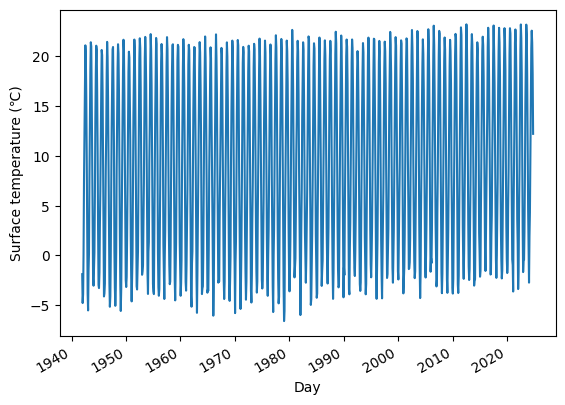

In [10]:
temp_series.plot(label=country_code)
plt.ylabel("Surface temperature (℃)")

Not surprisingly, there is a strong seasonal pattern.
We can use `seasonal_decompose` from StatsModels to identify a long-term trend, a seasonal component, and a residual.

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(temp_series, model="additive", period=12)

We'll use the following function to plot the results.

In [12]:
def plot_decomposition(original, decomposition):
    plt.figure(figsize=(6, 5))

    plt.subplot(4, 1, 1)
    plt.plot(original, label="Original", color="C0")
    plt.ylabel("Original")

    plt.subplot(4, 1, 2)
    plt.plot(decomposition.trend, label="Trend", color="C1")
    plt.ylabel("Trend")

    plt.subplot(4, 1, 3)
    plt.plot(decomposition.seasonal, label="Seasonal", color="C2")
    plt.ylabel("Seasonal")

    plt.subplot(4, 1, 4)
    plt.plot(decomposition.resid, label="Residual", color="C3")
    plt.ylabel("Residual")

    plt.tight_layout()

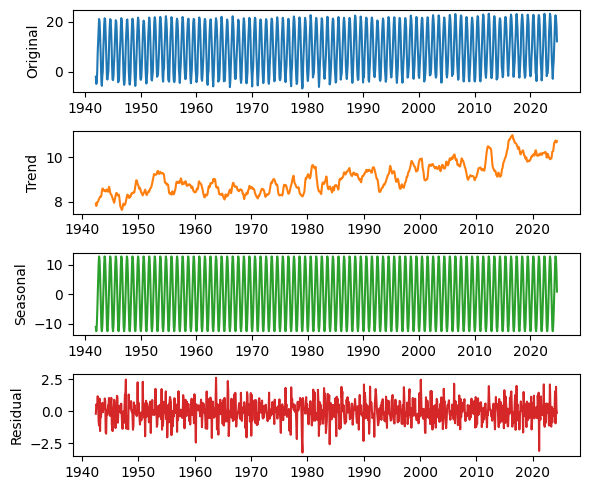

In [13]:
plot_decomposition(temp_series, decomposition)

As always, I'm grateful to Our World in Data for making datasets like this available, and now easier to use programmatically.

[Think Stats: Exploratory Data Analysis in Python, 3rd Edition](https://allendowney.github.io/ThinkStats/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)